In [1]:
import copy
import os

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RectBivariateSpline

import SSLimPy.interface.sslimpy as sslimpy

In [2]:
envkey = 'OMP_NUM_THREADS'
# Set this environment variable to the number of available cores in your machine,
# to get a fast execution of the Einstein Boltzmann Solver
os.environ[envkey] = str(14)

In [3]:
cosmodict={"h":0.67,"Omegam":0.32,"Omegab":0.04,"As":2.1e-9, "mnu":0.06}
settings = {"code":"class",
            "do_RSD" : True,
            "nonlinearRSD" : True,
            "FoG_damp" : "ISTF_like",
            "do_onehalo" : True,
            "halo_model_PS" : False,
            }
Asslimpy = sslimpy.sslimpy(settings_dict=settings,
                           cosmopars=cosmodict)

#--------------------------------------------------#

  SSSSS   SSSSS  L       i            PPPP   y    y 
 S     S S     S L            m   m   P    P y   y  
 S       S       L     iii   m m m m  P    P  y y   
  SSSSS   SSSSS  L       i   m  m  m  PPPP     y    
       S       S L       i   m     m  P        y    
 S     S S     S L       i   m     m  P       y     
  SSSSS   SSSSS  LLLLL iiiii m     m  P      y      

#--------------------------------------------------#


In [4]:
from SSLimPy.LIMsurvey import PowerSpectra
pobs = PowerSpectra.PowerSpectra(Asslimpy.fiducialcosmo,Asslimpy.fiducialastro)

In [5]:
from SSLimPy.LIMsurvey import Covariance
cov = Covariance.Covariance(Asslimpy.fiducialcosmo,pobs)

In [6]:
q = pobs.k
mu = pobs.mu
W, _ = cov.Wsurvey(q,mu)
W.shape

(199, 127, 1)

Text(0, 0.5, '$ \\|W_\\mathrm{survey}\\| [\\mathrm{Mpc}^{3}] $')

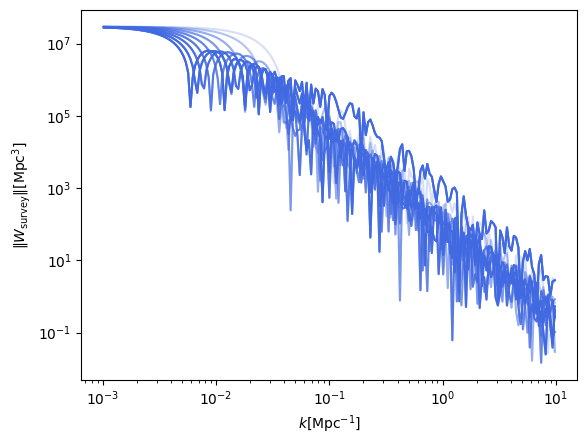

In [7]:
index = np.array(range(19))
for i in index:
    plt.loglog(q,np.abs(W[:,i*7,0]), c="RoyalBlue", alpha=np.abs(mu[i*7]))
plt.xlabel(r"$ k [\mathrm{Mpc}^{-1}] $")
plt.ylabel(r"$ \|W_\mathrm{survey}\| [\mathrm{Mpc}^{3}] $")


Text(0, 0.5, '$ P [\\mathrm{Mpc}^{3}] $')

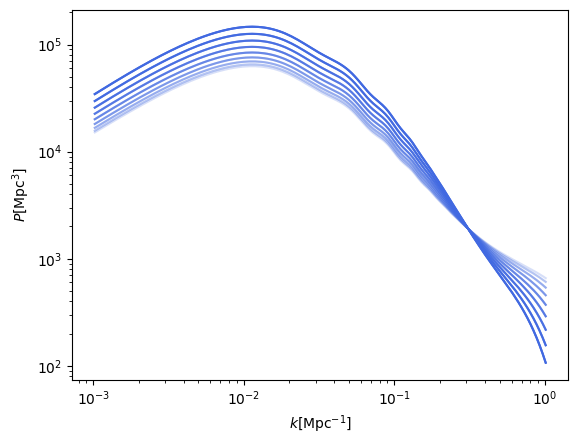

In [8]:
Pk = pobs.Pk_Obs
for i in index:
    plt.loglog(q[:150],Pk[:150,i*7,0], c="RoyalBlue", alpha=np.abs(mu[i*7]))
plt.xlabel(r"$ k [\mathrm{Mpc}^{-1}] $")
plt.ylabel(r"$ P [\mathrm{Mpc}^{3}] $")


In [9]:
k = pobs.k
mu = pobs.mu
pk_inter = RectBivariateSpline(np.log(k.value),mu,np.log(Pk[:,:,0].value))


In [10]:
deltaphi = np.linspace(-np.pi, np.pi)
muq = copy.copy(mu)
# Testing stuff 
q = 2e-2
k = 7e-2

kmq = np.empty((*mu.shape,*muq.shape,*deltaphi.shape))
mukmq = np.empty_like(kmq)
for imu, mui in enumerate(mu):
    for imuq, muqi in enumerate(muq):
        for idp, dpi in enumerate(deltaphi):
            kmq[imu,imuq,idp] = np.sqrt(
                k**2 + q**2 - 2 * q * k 
                * ( mui * muqi
                + np.sqrt(1 - mui**2)
                * np.sqrt(1 - muqi**2)
                * np.cos(dpi))
                )
            mukmq[imu,imuq,idp] = (k*mui - q*muqi) / kmq[imu,imuq,idp]

In [11]:
Pkmq= pk_inter(kmq,mukmq,grid=False)

Done!


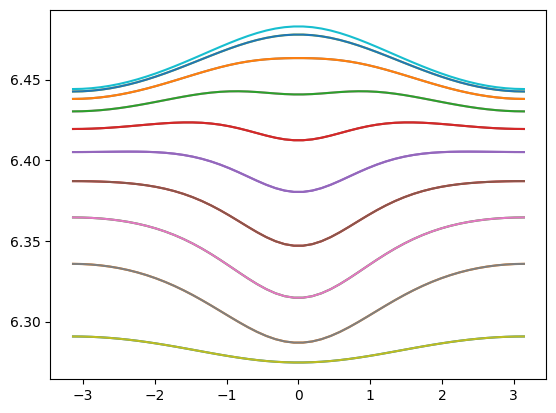

In [12]:
plt.plot(deltaphi,Pkmq[63,::7,:].T)
print("Done!")

In [13]:
I1 = np.trapz(Pkmq,deltaphi,axis=-1)

Done!


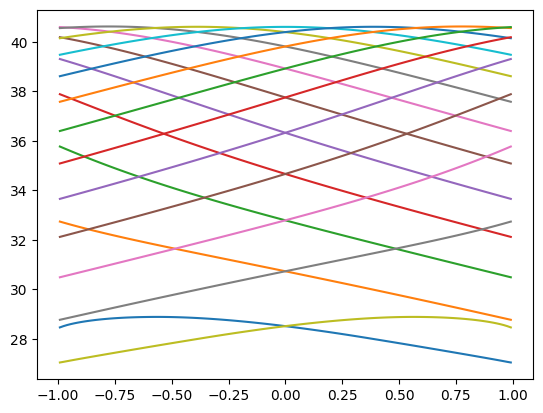

In [14]:
plt.plot(muq,I1[::7,:].T)
print("Done!")

Done!


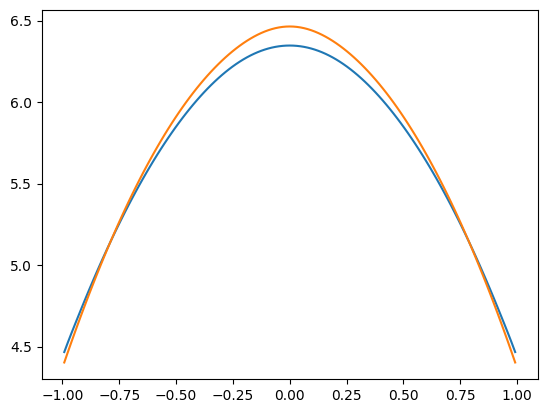

In [15]:
I2 = np.trapz(I1,muq,axis=-1)
plt.plot(mu,I2/(4*np.pi))
plt.plot(mu,pk_inter(7e-2,mu,grid=False))
print("Done!")

In [16]:
Pconv = cov.convolved_Pk()

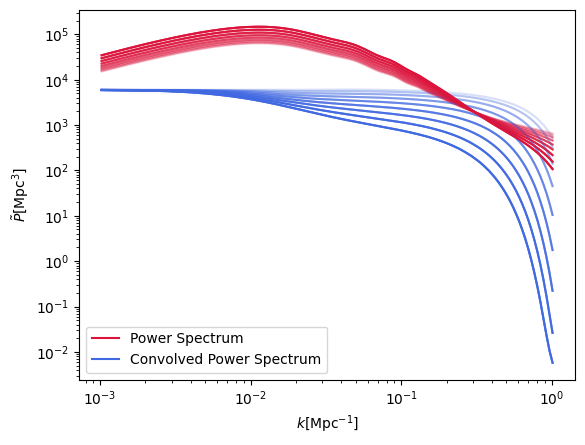

In [22]:
k = cov.powerspectrum.k

for i in index:
    plt.loglog(k[:150],Pk[:150,i*7,0], c="crimson", alpha=np.abs(mu[i*7]))
    plt.loglog(k[:150],Pconv[:150,i*7,0], c="RoyalBlue", alpha=np.abs(mu[i*7]))
plt.xlabel(r"$ k [\mathrm{Mpc}^{-1}] $")
plt.ylabel(r"$ \tilde{P} [\mathrm{Mpc}^{3}] $")
plt.plot([],[],c="crimson", label="Power Spectrum")
plt.plot([],[],c="royalblue", label="Convolved Power Spectrum")
plt.legend()

In [23]:
import SSLimPy.interface.config as cfg
nu = cov.powerspectrum.nu
nuObs = cov.powerspectrum.nuObs
Delta_nu = cfg.obspars["Delta_nu"]
z = (nu / nuObs - 1).to(1).value
z_min = (nu / (nuObs + Delta_nu / 2) - 1).to(1).value
z_max = (nu / (nuObs - Delta_nu / 2) - 1).to(1).value

In [24]:
Sfield = cov.Sfield(z, cfg.obspars["Omega_field"])
Lperp = np.sqrt(Sfield / np.pi)
Lparr = cov.Lfield(z_min, z_max)

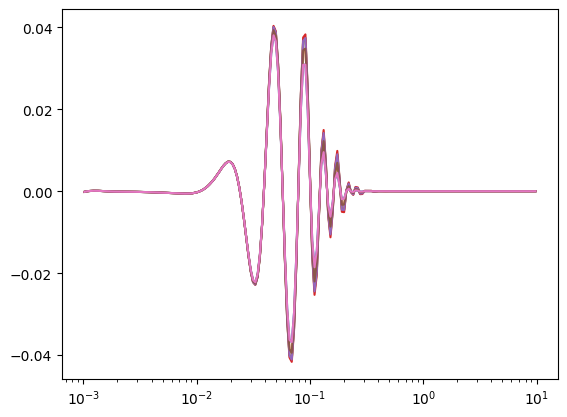

In [25]:
from scipy.interpolate import RectBivariateSpline
k = pobs.k
mu = np.linspace(-1,1,7)
Pk_dw_grid = pobs.dewiggled_pdd(pobs.k,mu,pobs.z)
Pk_nw_grid = Asslimpy.fiducialcosmo.nonwiggle_pow(pobs.k,pobs.z)[:,None]
test_1 = Pk_dw_grid/Pk_nw_grid-1
inter_over = RectBivariateSpline(np.log(k.value),mu,test_1)
plt.plot(k,inter_over(np.log(k.value),mu))
plt.xscale("log")

In [26]:
Asslimpy.fiducialastro.CLT(pobs.z)

<Quantity [0.00104043] Mpc3 uK / solLum>

In [27]:
print(Asslimpy.fiducialastro.Tmoments(pobs.z))
print(Asslimpy.fiducialastro.Tmoments(pobs.z,moment=2))

[1.49946184] uK
[895.78840942] Mpc3 uK2


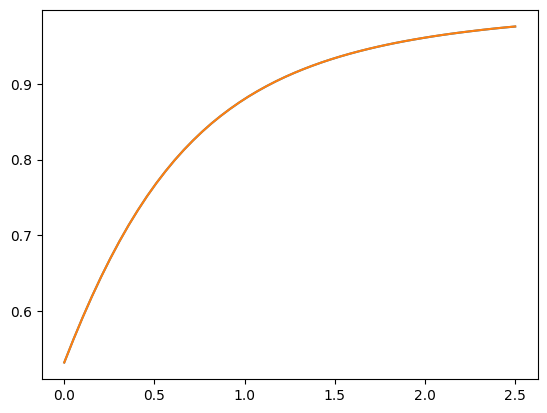

In [29]:
z = np.linspace(0,2.5)
plt.plot(z,Asslimpy.fiducialcosmo.growth_rate(1e-4/u.Mpc,z,tracer="matter"))
plt.plot(z,Asslimpy.fiducialcosmo.growth_rate(1e-4/u.Mpc,z,tracer="clustering"))

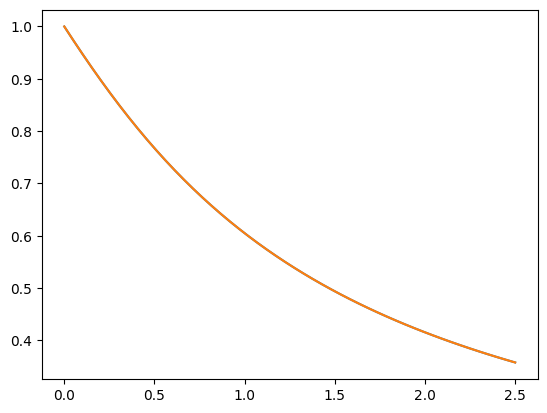

In [30]:
z = np.linspace(0,2.5)
plt.plot(z,Asslimpy.fiducialcosmo.growth_factor(1e-4/u.Mpc,z,tracer="matter"))
plt.plot(z,Asslimpy.fiducialcosmo.growth_factor(1e-4/u.Mpc,z,tracer="clustering"))

In [31]:
k = np.array(range(4))* 1e-3 / u.Mpc
Asslimpy.fiducialcosmo.growth_factor(k,z=np.array(range(4)))

/home/sefa/Desktop/LIM-Code/SSLimPy/SSLimPy/cosmology/cosmology.py:1013: RuntimeWarning: divide by zero encountered in log
  logk = np.log(k.to(1/u.Mpc).value)


array([[1.        , 0.60485487, 0.4153741 , 0.31386046],
       [1.        , 0.60515074, 0.41580346, 0.31435095],
       [1.        , 0.60519359, 0.4158754 , 0.31444532],
       [1.        , 0.60522031, 0.41591649, 0.31449419]])

In [32]:
Asslimpy.fiducialcosmo.P_ThetaTheta_Moments(np.array(range(4)))

<Quantity [9.06127778, 5.48873691, 3.77446819, 2.85551479] Mpc>

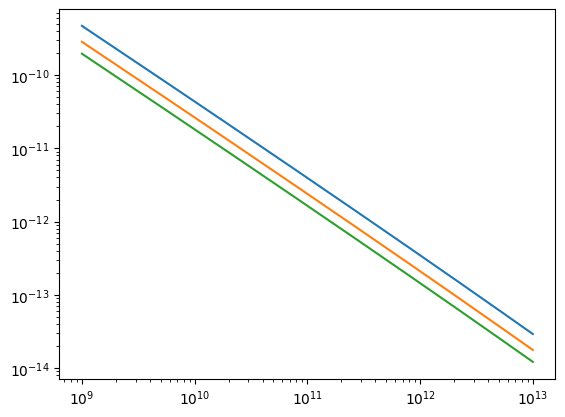

In [33]:
M = np.geomspace(1e9,1e13,200)*u.Msun
plt.loglog(M,-1*Asslimpy.fiducialastro.dsigmaM_dM(M,np.array(range(3))))

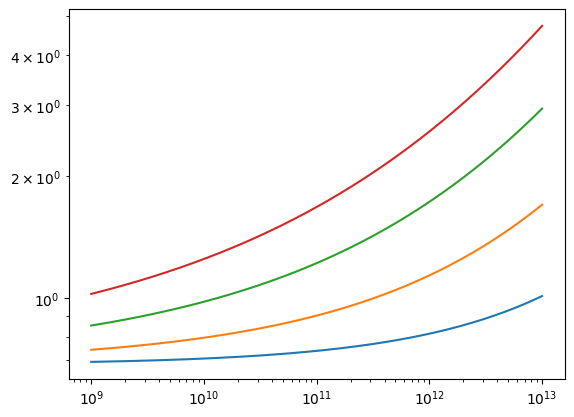

In [34]:
plt.loglog(M,Asslimpy.fiducialastro.halobias(M,np.array(range(4))))

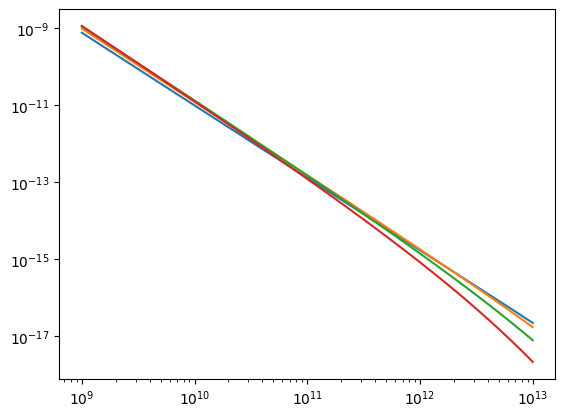

In [35]:
plt.loglog(M,Asslimpy.fiducialastro.halomassfunction(M,np.array(range(4))))